In [2]:
from claims_known import experiment
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import matplotlib.collections as mcol

### Partial BF Lottery: Expected Utility vs Randomization Rate

100%|██████████████████████████████████████| 1000/1000 [00:05<00:00, 178.56it/s]


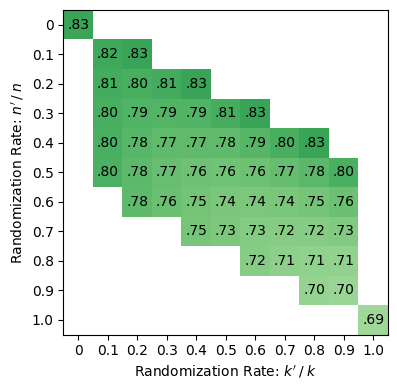

In [50]:
dist = "inv_normal"
selection_rate = 0.50

e = experiment(dist, 0.5, 0.15)
res = e.partial_bf_randomization_rate(selection_rate)

res = res[["perc_random_k", "perc_random_n", "random_util"]]
util_diff = []
for perc_random_n in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
    inner = []
    for perc_random_k in [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]:
        if (perc_random_k == 0) and (perc_random_n != 0):
            inner.append(np.nan)
            continue
        elif (perc_random_k == 1) and (perc_random_n != 1):
            inner.append(np.nan)
            continue

        val = res.loc[(res["perc_random_k"]==perc_random_k)&(res["perc_random_n"]==perc_random_n), "random_util"].to_numpy()
        if len(val)>0:
            inner.append(np.abs(val[0]))
        else:
            inner.append(np.nan)
    util_diff.append(inner)

plt.rcParams["figure.figsize"] = [5, 4]
fig, ax = plt.subplots()

plt.imshow(util_diff, cmap='Greens', vmin=0.5, vmax=1.0, interpolation='nearest')

ax.set_xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_yticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=[0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
ax.set_xlabel('Randomization Rate: $k\'\\,$/$\\;k$')
ax.set_ylabel('Randomization Rate: $n\'\\,$/$\\;n$')

for (j,i),label in np.ndenumerate(util_diff):
    if pd.notna(label):        
        ax.text(i,j,"{:.2f}".format(label)[1:],ha='center',va='center')

ax.set_facecolor('w')
plt.tight_layout()
plt.savefig(dist+'_partial_'+str(selection_rate).replace("0.", "")+'.jpg', format='jpg', dpi=500)
plt.show()

### Partial BF Lottery: Expected Utility vs SER

In [117]:
dist = "uniform"
sr = 0.10
e = experiment(dist, 2,1)

res_utility = e.partial_bf_randomization_rate(sr)
res_ser_noise0 = e.systemic_exclusion_randomization_rate(selection_rate=sr, noise_std=0, num_decision_makers=4, iterations=1000)
res_ser_noise1 = e.systemic_exclusion_randomization_rate(selection_rate=sr, noise_std=0.025, num_decision_makers=4, iterations=1000)
res_ser_noise2 = e.systemic_exclusion_randomization_rate(selection_rate=sr, noise_std=0.05, num_decision_makers=4, iterations=1000)

res_ser = [res_ser_noise0, res_ser_noise1, res_ser_noise2]
res_utility = res_utility[["random_k", "random_n", "util_diff", "random_util"]]

for i,rs in enumerate(res_ser):
    rs = rs[["m", "random_k", "random_n", "ser_diff", "random_ser"]]
    rs = rs.merge(res_utility, on=["random_k", "random_n"], how="left")
    rs["ser_diff"] = rs["ser_diff"].round(2)
    rs["util_diff"] = rs["util_diff"].round(2)
    
    res_ser[i] = rs.groupby(["m", "util_diff"]).max().reset_index()

100%|███████████████████████████████████████| 1000/1000 [00:21<00:00, 46.20it/s]


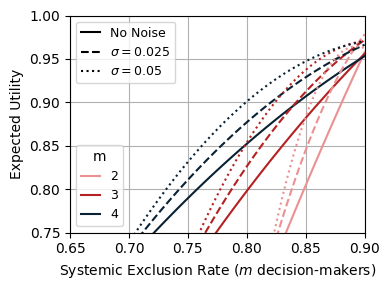

In [120]:
def fit_curve(raw_x, raw_y):
    model = np.polyfit(raw_x, raw_y, deg=2)
    x = np.linspace((1-sr)**5, (1-sr), 100)
    y = model[0]*(x**2) + model[1]*(x) + model[2]
    return x,y
    
plt.rcParams["figure.figsize"] = [4,3]
fig, ax = plt.subplots()

noise=0
x,y = fit_curve(res_ser[noise].loc[res_ser[noise]["m"]==2, "random_ser"], res_ser[noise].loc[res_ser[noise]["m"]==2, "random_util"])
plt.plot(x,y, color="#eb9191", label="2")

x,y = fit_curve(res_ser[noise].loc[res_ser[noise]["m"]==3, "random_ser"], res_ser[noise].loc[res_ser[noise]["m"]==3, "random_util"])
plt.plot(x,y, color="#b32122", label="3")

x,y = fit_curve(res_ser[noise].loc[res_ser[noise]["m"]==4, "random_ser"], res_ser[noise].loc[res_ser[noise]["m"]==4, "random_util"])
plt.plot(x,y, color="#092132", label="4")

noise=1
x,y = fit_curve(res_ser[noise].loc[res_ser[noise]["m"]==2, "random_ser"], res_ser[noise].loc[res_ser[noise]["m"]==2, "random_util"])
plt.plot(x,y, linestyle="dashed", color="#eb9191")

x,y = fit_curve(res_ser[noise].loc[res_ser[noise]["m"]==3, "random_ser"], res_ser[noise].loc[res_ser[noise]["m"]==3, "random_util"])
plt.plot(x,y, linestyle="dashed", color="#b32122")

x,y = fit_curve(res_ser[noise].loc[res_ser[noise]["m"]==4, "random_ser"], res_ser[noise].loc[res_ser[noise]["m"]==4, "random_util"])
plt.plot(x,y, linestyle="dashed", color="#092132")

noise=2
x,y = fit_curve(res_ser[noise].loc[res_ser[noise]["m"]==2, "random_ser"], res_ser[noise].loc[res_ser[noise]["m"]==2, "random_util"])
plt.plot(x,y, linestyle="dotted", color="#eb9191")

x,y = fit_curve(res_ser[noise].loc[res_ser[noise]["m"]==3, "random_ser"], res_ser[noise].loc[res_ser[noise]["m"]==3, "random_util"])
plt.plot(x,y, linestyle="dotted", color="#b32122")

x,y = fit_curve(res_ser[noise].loc[res_ser[noise]["m"]==4, "random_ser"], res_ser[noise].loc[res_ser[noise]["m"]==4, "random_util"])
plt.plot(x,y, linestyle="dotted", color="#092132")

#ax.text(0.0375, 0.61, "k/n = "+str(sr), transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor="white", edgecolor="0.8"))

first_legend = plt.legend(title="m", loc="lower left", fontsize=9, handlelength=1.5)

ax = plt.gca().add_artist(first_legend)


blue_line = mlines.Line2D([], [], color="k", linestyle="solid", label="No Noise")
blue_line2 = mlines.Line2D([], [],  color="k", linestyle="dashed", label="$\\sigma=0.025$")
blue_line3 = mlines.Line2D([], [],  color="k", linestyle="dotted", label="$\\sigma=0.05$")

plt.legend(handles=[blue_line, blue_line2, blue_line3], loc="upper left", fontsize=9, handlelength=1.5)

#plt.plot(results["all"]["k"], results["all"]['util_diff'], color="k", label="Avg. All Models")


plt.xlim([0.65, 0.90])
plt.ylim([0.75, 1.0])

plt.xlabel("Systemic Exclusion Rate ($m$ decision-makers)")
plt.ylabel("Expected Utility")

plt.grid()
plt.tight_layout()
plt.savefig(dist+'_ser_'+str(sr).replace("0.", "")+'.jpg', format='jpg', dpi=500)
plt.show()

## Comparing Distributions

In [3]:
dist = "normal"
sr = 0.25
e = experiment(dist, 0.5, 0.15)
gaussian_utility = e.partial_bf_randomization_rate(sr)
gaussian_ser = e.systemic_exclusion_randomization_rate(selection_rate=sr, noise_std=0.025, num_decision_makers=4, iterations=1000)

100%|███████████████████████████████████████| 1000/1000 [00:29<00:00, 33.78it/s]


In [7]:
dist = "inv_pareto"
sr = 0.25
e = experiment(dist, 2, 1)
inv_pareto_utility = e.partial_bf_randomization_rate(sr)
inv_pareto_ser = e.systemic_exclusion_randomization_rate(selection_rate=sr, noise_std=0.025, num_decision_makers=4, iterations=1000)

100%|███████████████████████████████████████| 1000/1000 [00:27<00:00, 36.00it/s]


In [8]:
def clean_res(ru, rs):
    ru = ru[["random_k", "random_n", "util_diff", "random_util"]]
    rs = rs[["m", "random_k", "random_n", "ser_diff", "random_ser"]]
    rs = rs.merge(ru, on=["random_k", "random_n"], how="left")
    rs["ser_diff"] = rs["ser_diff"].round(2)
    rs["util_diff"] = rs["util_diff"].round(2)
    rs = rs.groupby(["m", "util_diff"]).max().reset_index()
    return ru, rs

In [9]:
gaussian_utility, gaussian_ser = clean_res(gaussian_utility, gaussian_ser)

In [10]:
inv_pareto_utility, inv_pareto_ser = clean_res(inv_pareto_utility, inv_pareto_ser)

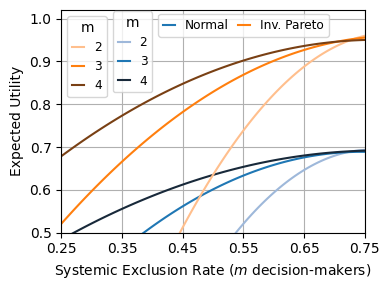

In [53]:
def fit_curve(raw_x, raw_y):
    model = np.polyfit(raw_x, raw_y, deg=2)
    x = np.linspace((1-sr)**5, (1-sr), 100)
    y = model[0]*(x**2) + model[1]*(x) + model[2]
    return x,y
    
plt.rcParams["figure.figsize"] = [4,3]
fig, ax = plt.subplots()

x,y = fit_curve(gaussian_ser.loc[gaussian_ser["m"]==2, "random_ser"], gaussian_ser.loc[gaussian_ser["m"]==2, "random_util"])
plt.plot(x,y, color="#9eb8da")

x,y = fit_curve(gaussian_ser.loc[gaussian_ser["m"]==3, "random_ser"], gaussian_ser.loc[gaussian_ser["m"]==3, "random_util"])
plt.plot(x,y, color="#1f77b4")

x,y = fit_curve(gaussian_ser.loc[gaussian_ser["m"]==4, "random_ser"], gaussian_ser.loc[gaussian_ser["m"]==4, "random_util"])
plt.plot(x,y, color="#18293a")

x,y = fit_curve(inv_pareto_ser.loc[inv_pareto_ser["m"]==2, "random_ser"], inv_pareto_ser.loc[inv_pareto_ser["m"]==2, "random_util"])
plt.plot(x,y, color="#ffbf8d", label="2")

x,y = fit_curve(inv_pareto_ser.loc[inv_pareto_ser["m"]==3, "random_ser"], inv_pareto_ser.loc[inv_pareto_ser["m"]==3, "random_util"])
plt.plot(x,y, color="#ff7f0e", label="3")

x,y = fit_curve(inv_pareto_ser.loc[inv_pareto_ser["m"]==4, "random_ser"], inv_pareto_ser.loc[inv_pareto_ser["m"]==4, "random_util"])
plt.plot(x,y, color="#794014", label="4")

#ax.text(0.215, 0.9475, "k/n = "+str(sr), transform=ax.transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor="white", edgecolor="0.8"))

first_legend = plt.legend(loc="upper left", title="m", handlelength=1, fontsize=8.75)

blue_line = mlines.Line2D([], [], color='#1f77b4', label="Normal")
blue_line2 = mlines.Line2D([], [], color='#ff7f0e', label="Inv. Pareto")

second_legend = plt.legend(handles=[blue_line, blue_line2], loc=(0.32, 0.88), ncol=2, handlelength=1, fontsize=8.75,columnspacing=0.75)

blue_line = mlines.Line2D([], [], color='#9eb8da', label="2")
blue_line2 = mlines.Line2D([], [], color='#1f77b4', label="3")
blue_line3 = mlines.Line2D([], [], color='#18293a', label="4")

plt.legend(handles=[blue_line, blue_line2, blue_line3], loc=(0.17, 0.63), title="m", ncol=1, handlelength=1, fontsize=8.75,columnspacing=0.75)

ax = plt.gca().add_artist(first_legend)
ax = plt.gca().add_artist(second_legend)

plt.xticks([0.25, 0.35, 0.45, 0.55, 0.65, 0.75])
plt.xlim([0.25, 0.75])
plt.ylim([0.5,1.02])
plt.xlabel("Systemic Exclusion Rate ($m$ decision-makers)")
plt.ylabel("Expected Utility")

plt.grid()
plt.tight_layout()
plt.savefig('1_claims_utility_ser.jpg', format='jpg', dpi=500)
plt.show()